In [78]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import glob
import os
from datetime import datetime
warnings.filterwarnings('ignore')

# Set up clean plotting style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Define consistent colors for libraries
library_colors = {
    'schema-json-patch': '#2E8B57',      # Sea Green
    'fast-json-patch': '#4169E1',        # Royal Blue  
    'jsondiffpatch': '#FF6347',          # Tomato
    'schema-aggregated': '#8B4513',      # Saddle Brown
    'json-diff-kit': '#9932CC'          # Dark Orchid
}

# Alternative color scheme for formatted diff
formatted_diff_colors = {
    'schema-aggregated': '#FF6B35',      # Vibrant Orange
    'json-diff-kit': '#004E89'           # Deep Blue
}

print("✅ Libraries imported and styling configured!")


✅ Libraries imported and styling configured!


In [79]:
# Load and prepare both raw patch and formatted diff data
def find_latest_csv(pattern):
    """Find the most recent CSV file matching the pattern"""
    files = glob.glob(f'../comparison/{pattern}')
    if not files:
        return None
    return max(files, key=os.path.getctime)

# Find the latest benchmark files
raw_patch_csv = find_latest_csv('benchmark-results-*.csv')
formatted_diff_csv = find_latest_csv('formatted-diff-results-*.csv')

# Load raw patch performance data
raw_df = None
if raw_patch_csv:
    try:
        raw_df = pd.read_csv(raw_patch_csv)
        print(f"✅ Raw Patch Data: {len(raw_df):,} records from {os.path.basename(raw_patch_csv)}")
        print(f"📊 Raw patch libraries: {', '.join(raw_df['library'].unique())}")
        
        # Data preprocessing for raw patch data
        if 'throughput' not in raw_df.columns:
            raw_df['throughput'] = 1000 / raw_df['executionTime']
        if 'memoryKB' not in raw_df.columns:
            raw_df['memoryKB'] = raw_df['memoryUsage'] / 1024
        if 'patchEfficiency' not in raw_df.columns:
            raw_df['patchEfficiency'] = raw_df['patchCount'] / raw_df['documentSize'] * 1000
            
    except Exception as e:
        print(f"❌ Error loading raw patch data: {e}")
else:
    print("❌ No raw patch benchmark file found")

# Load formatted diff data  
formatted_df = None
if formatted_diff_csv:
    try:
        formatted_df = pd.read_csv(formatted_diff_csv)
        print(f"✅ Formatted Diff Data: {len(formatted_df):,} records from {os.path.basename(formatted_diff_csv)}")
        print(f"🎨 Formatted diff libraries: {', '.join(formatted_df['library'].unique())}")
        
        # Data preprocessing for formatted diff data
        if 'throughput' not in formatted_df.columns:
            formatted_df['throughput'] = 1000 / formatted_df['executionTime']
        if 'memoryKB' not in formatted_df.columns:
            formatted_df['memoryKB'] = formatted_df['memoryUsage'] / 1024
        if 'outputSizeKB' not in formatted_df.columns:
            formatted_df['outputSizeKB'] = formatted_df['outputSize'] / 1024
            
    except Exception as e:
        print(f"❌ Error loading formatted diff data: {e}")
else:
    print("❌ No formatted diff benchmark file found")

# Create complexity categories for both datasets
def add_complexity_categories(df):
    df['complexityLevel'] = pd.cut(df['complexityScore'], 
                                  bins=[0, 50, 200, 500, float('inf')], 
                                  labels=['Low', 'Medium', 'High', 'Very High'])
    
    df['sizeCategory'] = pd.cut(df['documentSize'], 
                               bins=5, 
                               labels=['Small', 'Medium', 'Large', 'Very Large', 'Huge'])
    return df

if raw_df is not None:
    raw_df = add_complexity_categories(raw_df)
    
if formatted_df is not None:
    formatted_df = add_complexity_categories(formatted_df)

print("✅ Data preprocessing complete!")


✅ Raw Patch Data: 15,000 records from benchmark-results-2025-06-27.csv
📊 Raw patch libraries: schema-json-patch, fast-json-patch, jsondiffpatch
✅ Formatted Diff Data: 10,000 records from formatted-diff-results-2025-06-27.csv
🎨 Formatted diff libraries: schema-aggregated, json-diff-kit
✅ Data preprocessing complete!


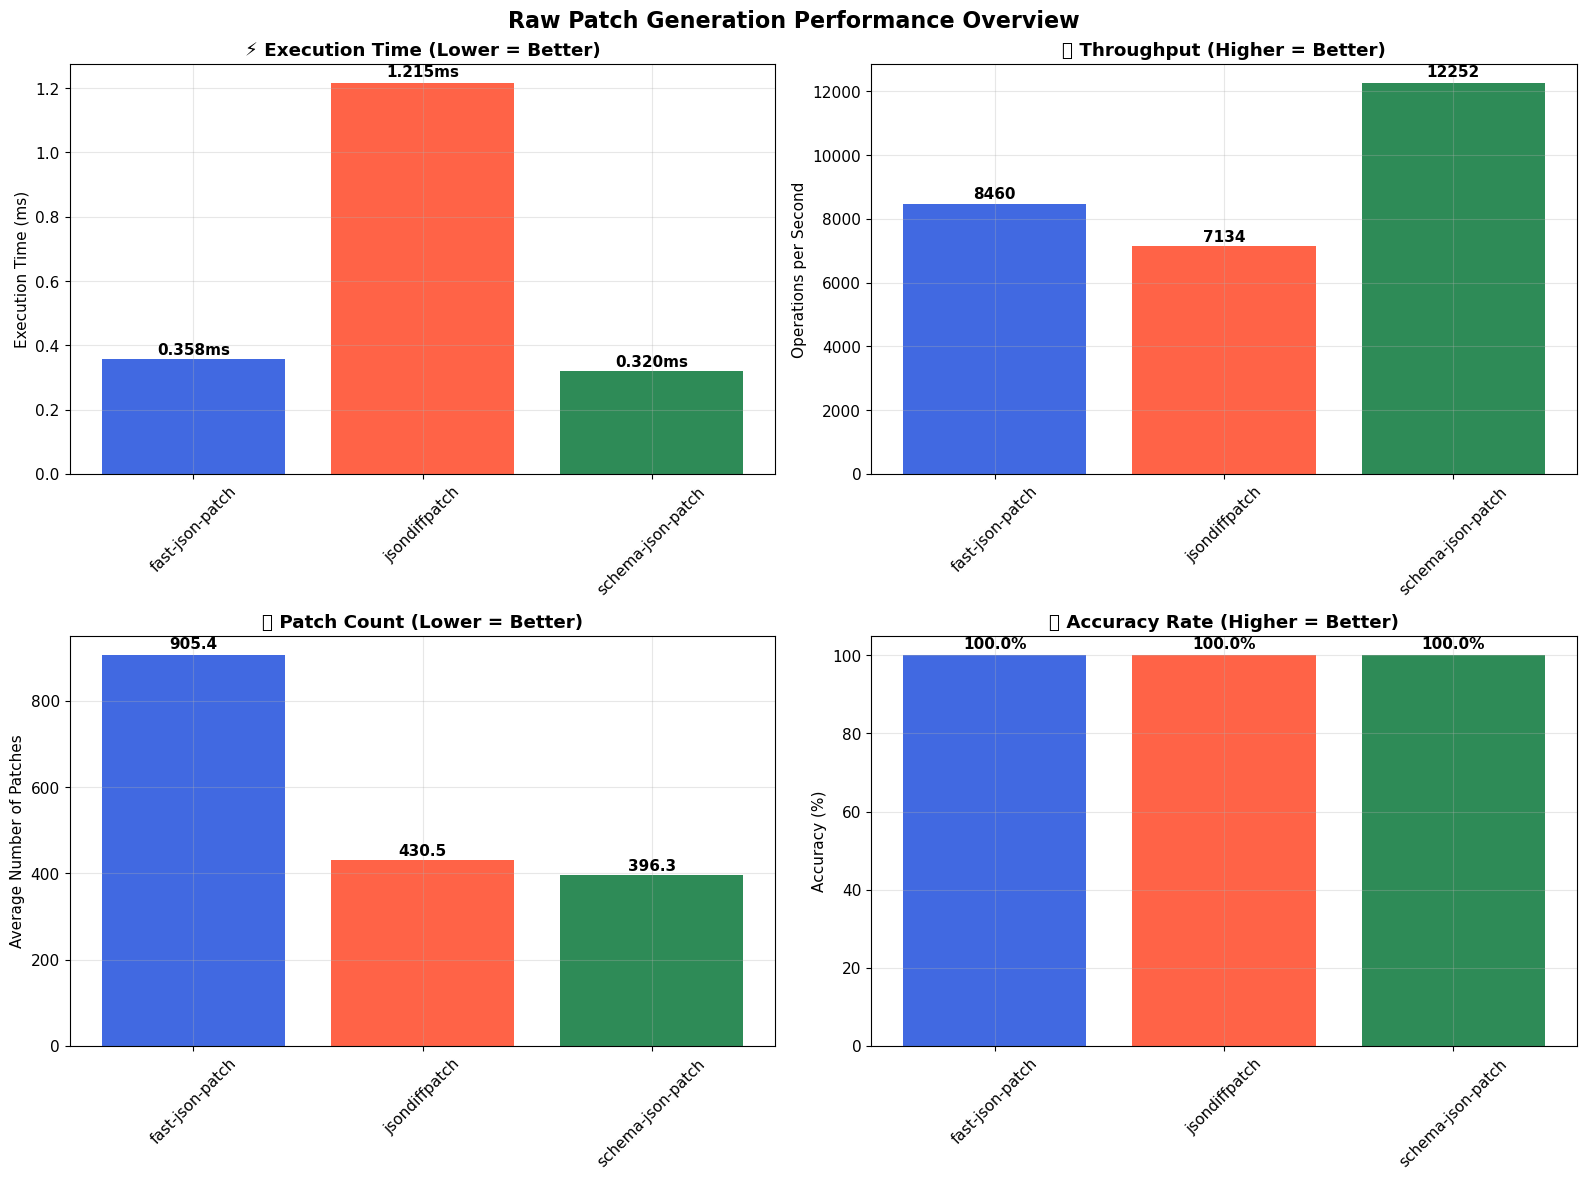

📊 Raw Patch Performance Summary:
                   executionTime  throughput  patchCount  memoryKB  accuracy  patchEfficiency
library                                                                                      
fast-json-patch            0.358    8459.610     905.416     5.154       1.0            8.139
jsondiffpatch              1.215    7134.143     430.494    39.161       1.0            3.927
schema-json-patch          0.320   12252.478     396.258    11.484       1.0            3.639


In [80]:
# Raw Patch Performance Overview - Bar Charts
if raw_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Raw Patch Generation Performance Overview', fontsize=16, fontweight='bold')

    # Calculate summary statistics for each library
    summary_stats = raw_df.groupby('library').agg({
        'executionTime': 'mean',
        'throughput': 'mean', 
        'patchCount': 'mean',
        'memoryKB': 'mean',
        'accuracy': 'mean',
        'patchEfficiency': 'mean'
    }).round(3)

    # 1. Average Execution Time (Lower is Better)
    ax1 = axes[0, 0]
    bars1 = ax1.bar(summary_stats.index, summary_stats['executionTime'], 
                   color=[library_colors.get(lib, '#888888') for lib in summary_stats.index])
    ax1.set_title('⚡ Execution Time (Lower = Better)', fontweight='bold')
    ax1.set_ylabel('Execution Time (ms)')
    ax1.tick_params(axis='x', rotation=45)
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:.3f}ms', ha='center', va='bottom', fontweight='bold')

    # 2. Average Throughput (Higher is Better)
    ax2 = axes[0, 1] 
    bars2 = ax2.bar(summary_stats.index, summary_stats['throughput'],
                   color=[library_colors.get(lib, '#888888') for lib in summary_stats.index])
    ax2.set_title('🚀 Throughput (Higher = Better)', fontweight='bold')
    ax2.set_ylabel('Operations per Second')
    ax2.tick_params(axis='x', rotation=45)
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

    # 3. Average Patch Count (Lower is Better)
    ax3 = axes[1, 0]
    bars3 = ax3.bar(summary_stats.index, summary_stats['patchCount'],
                   color=[library_colors.get(lib, '#888888') for lib in summary_stats.index])
    ax3.set_title('📏 Patch Count (Lower = Better)', fontweight='bold')
    ax3.set_ylabel('Average Number of Patches')
    ax3.tick_params(axis='x', rotation=45)
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

    # 4. Accuracy Rate (Higher is Better)
    ax4 = axes[1, 1]
    bars4 = ax4.bar(summary_stats.index, summary_stats['accuracy'] * 100,
                   color=[library_colors.get(lib, '#888888') for lib in summary_stats.index])
    ax4.set_title('✅ Accuracy Rate (Higher = Better)', fontweight='bold')
    ax4.set_ylabel('Accuracy (%)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.set_ylim(0, 105)
    for bar in bars4:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("📊 Raw Patch Performance Summary:")
    print(summary_stats.to_string())
else:
    print("❌ No raw patch data available for visualization")


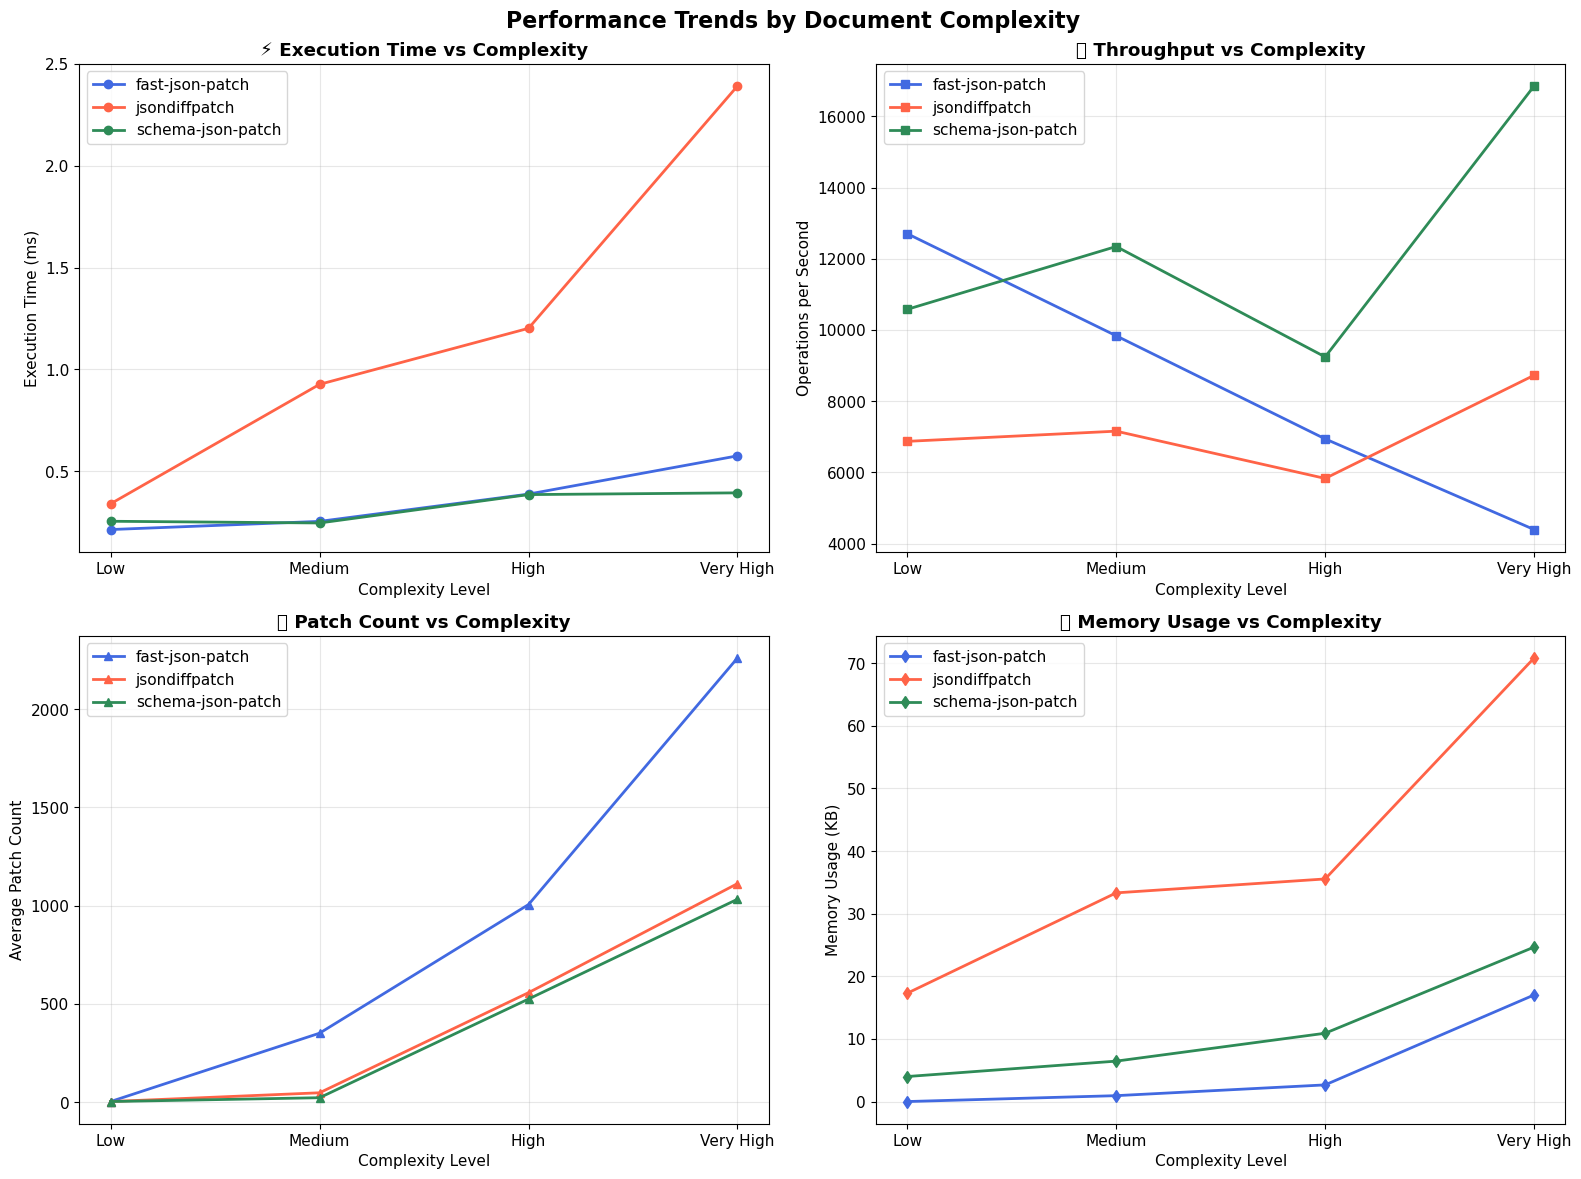

📈 Complexity trend analysis complete!


In [81]:
# Performance by Complexity Level
if raw_df is not None:
    # Create complexity analysis
    complexity_stats = raw_df.groupby(['library', 'complexityLevel']).agg({
        'executionTime': 'mean',
        'throughput': 'mean',
        'patchCount': 'mean',
        'memoryKB': 'mean'
    }).reset_index()

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Performance Trends by Document Complexity', fontsize=16, fontweight='bold')

    complexity_order = ['Low', 'Medium', 'High', 'Very High']

    # 1. Execution Time by Complexity
    ax1 = axes[0, 0]
    for library in complexity_stats['library'].unique():
        lib_data = complexity_stats[complexity_stats['library'] == library]
        ax1.plot(lib_data['complexityLevel'], lib_data['executionTime'], 
                marker='o', linewidth=2, markersize=6,
                color=library_colors.get(library, '#888888'),
                label=library)
    ax1.set_title('⚡ Execution Time vs Complexity', fontweight='bold')
    ax1.set_ylabel('Execution Time (ms)')
    ax1.set_xlabel('Complexity Level')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Throughput by Complexity  
    ax2 = axes[0, 1]
    for library in complexity_stats['library'].unique():
        lib_data = complexity_stats[complexity_stats['library'] == library]
        ax2.plot(lib_data['complexityLevel'], lib_data['throughput'],
                marker='s', linewidth=2, markersize=6,
                color=library_colors.get(library, '#888888'),
                label=library)
    ax2.set_title('🚀 Throughput vs Complexity', fontweight='bold')
    ax2.set_ylabel('Operations per Second')
    ax2.set_xlabel('Complexity Level')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Patch Count by Complexity
    ax3 = axes[1, 0]
    for library in complexity_stats['library'].unique():
        lib_data = complexity_stats[complexity_stats['library'] == library]
        ax3.plot(lib_data['complexityLevel'], lib_data['patchCount'],
                marker='^', linewidth=2, markersize=6,
                color=library_colors.get(library, '#888888'),
                label=library)
    ax3.set_title('📏 Patch Count vs Complexity', fontweight='bold')
    ax3.set_ylabel('Average Patch Count')
    ax3.set_xlabel('Complexity Level')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Memory Usage by Complexity
    ax4 = axes[1, 1]
    for library in complexity_stats['library'].unique():
        lib_data = complexity_stats[complexity_stats['library'] == library]
        ax4.plot(lib_data['complexityLevel'], lib_data['memoryKB'],
                marker='d', linewidth=2, markersize=6,
                color=library_colors.get(library, '#888888'),
                label=library)
    ax4.set_title('💾 Memory Usage vs Complexity', fontweight='bold')
    ax4.set_ylabel('Memory Usage (KB)')
    ax4.set_xlabel('Complexity Level')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("📈 Complexity trend analysis complete!")
else:
    print("❌ No raw patch data available for complexity analysis")


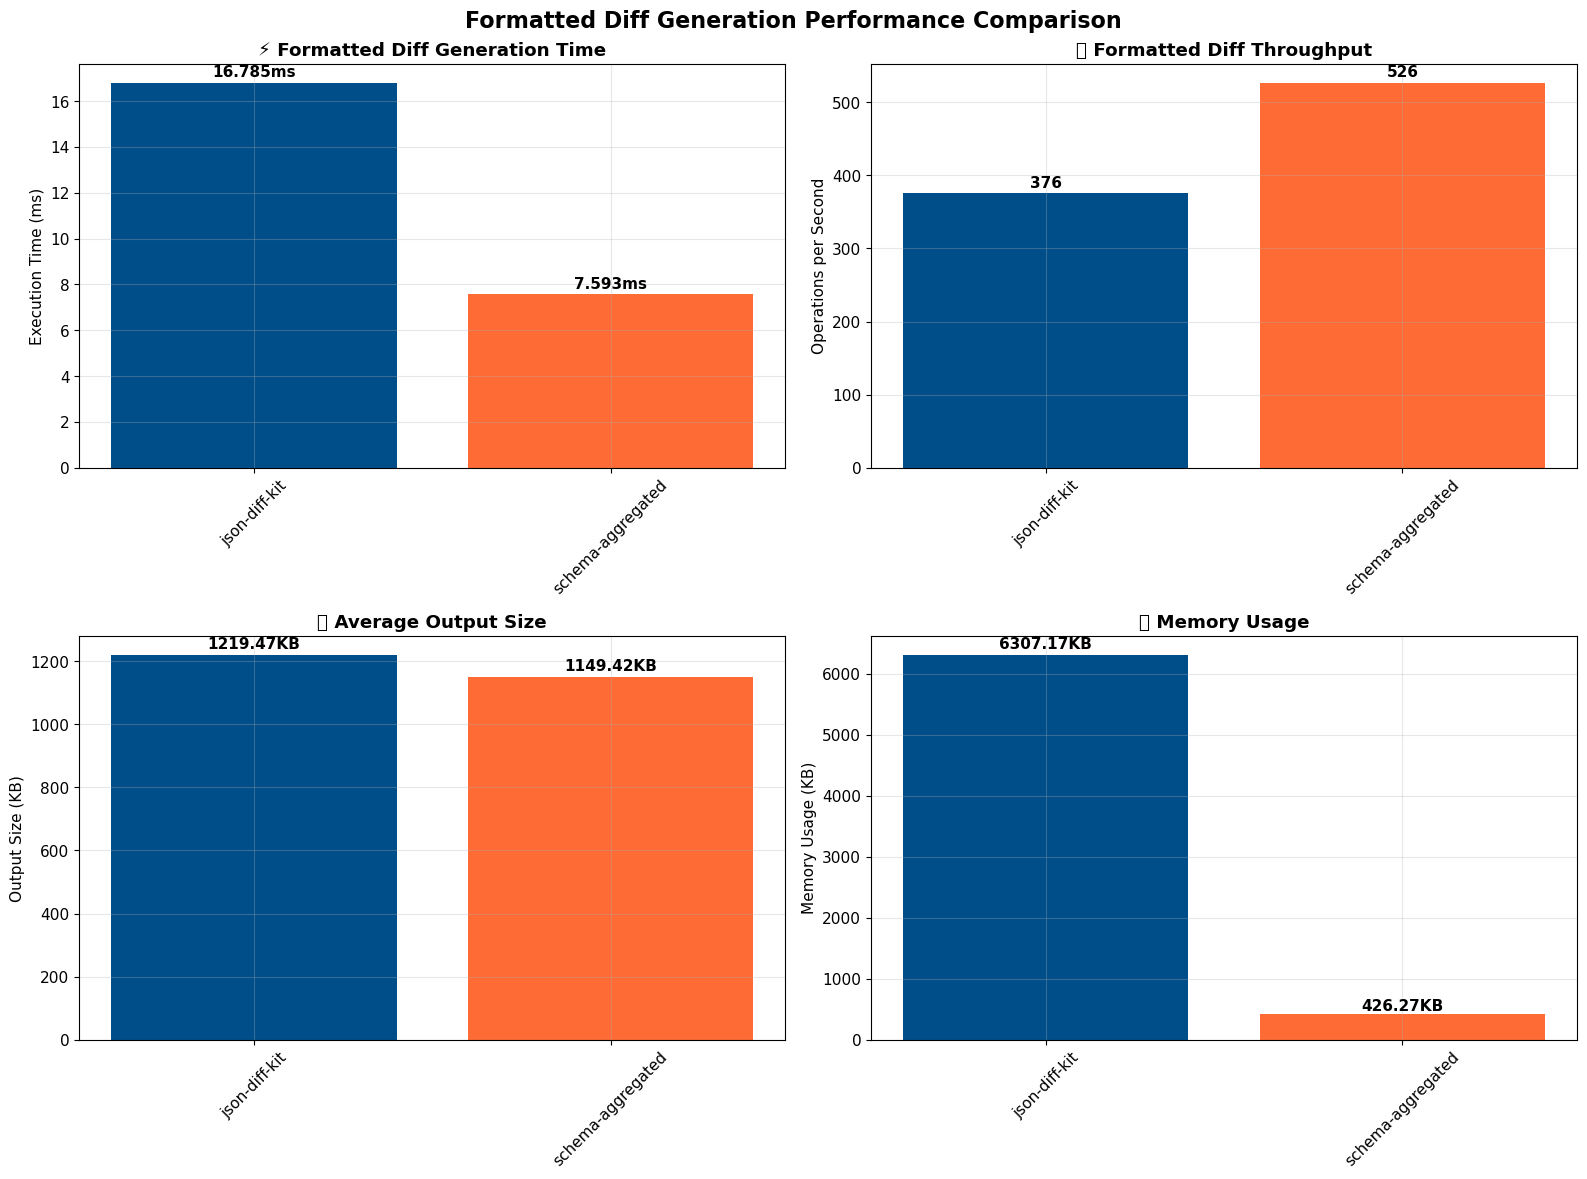

🏆 Formatted Diff Head-to-Head Comparison:
  ⚡ Speed: SchemaPatch+Aggregator is 0.55x faster
  📄 Output: SchemaPatch+Aggregator produces 0.06x smaller output
  💾 Memory: SchemaPatch+Aggregator uses 0.93x less memory
📊 Formatted Diff Performance Summary:
                   executionTime  throughput  outputSizeKB  memoryKB  compressionRatio
library                                                                               
json-diff-kit             16.785     376.130      1219.471  6307.172          1104.934
schema-aggregated          7.593     526.343      1149.418   426.267          1073.042


In [82]:
# Formatted Diff Performance Comparison
if formatted_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Formatted Diff Generation Performance Comparison', fontsize=16, fontweight='bold')

    # Calculate summary statistics for formatted diff libraries
    formatted_stats = formatted_df.groupby('library').agg({
        'executionTime': 'mean',
        'throughput': 'mean', 
        'outputSizeKB': 'mean',
        'memoryKB': 'mean',
        'compressionRatio': 'mean'
    }).round(3)

    # 1. Execution Time Comparison
    ax1 = axes[0, 0]
    bars1 = ax1.bar(formatted_stats.index, formatted_stats['executionTime'], 
                   color=[formatted_diff_colors.get(lib, '#888888') for lib in formatted_stats.index])
    ax1.set_title('⚡ Formatted Diff Generation Time', fontweight='bold')
    ax1.set_ylabel('Execution Time (ms)')
    ax1.tick_params(axis='x', rotation=45)
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:.3f}ms', ha='center', va='bottom', fontweight='bold')

    # 2. Throughput Comparison
    ax2 = axes[0, 1]
    bars2 = ax2.bar(formatted_stats.index, formatted_stats['throughput'], 
                   color=[formatted_diff_colors.get(lib, '#888888') for lib in formatted_stats.index])
    ax2.set_title('🚀 Formatted Diff Throughput', fontweight='bold')
    ax2.set_ylabel('Operations per Second')
    ax2.tick_params(axis='x', rotation=45)
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

    # 3. Output Size Comparison
    ax3 = axes[1, 0]
    bars3 = ax3.bar(formatted_stats.index, formatted_stats['outputSizeKB'],
                   color=[formatted_diff_colors.get(lib, '#888888') for lib in formatted_stats.index])
    ax3.set_title('📄 Average Output Size', fontweight='bold')
    ax3.set_ylabel('Output Size (KB)')
    ax3.tick_params(axis='x', rotation=45)
    for i, bar in enumerate(bars3):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:.2f}KB', ha='center', va='bottom', fontweight='bold')

    # 4. Memory Usage Comparison
    ax4 = axes[1, 1]
    bars4 = ax4.bar(formatted_stats.index, formatted_stats['memoryKB'],
                   color=[formatted_diff_colors.get(lib, '#888888') for lib in formatted_stats.index])
    ax4.set_title('💾 Memory Usage', fontweight='bold')
    ax4.set_ylabel('Memory Usage (KB)')
    ax4.tick_params(axis='x', rotation=45)
    for i, bar in enumerate(bars4):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:.2f}KB', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Calculate performance ratios
    if len(formatted_stats.index) == 2:
        libs = list(formatted_stats.index)
        schema_lib = 'schema-aggregated'
        json_diff_kit_lib = 'json-diff-kit'
        
        if schema_lib in libs and json_diff_kit_lib in libs:
            time_ratio = formatted_stats.loc[schema_lib, 'executionTime'] / formatted_stats.loc[json_diff_kit_lib, 'executionTime']
            size_ratio = formatted_stats.loc[schema_lib, 'outputSizeKB'] / formatted_stats.loc[json_diff_kit_lib, 'outputSizeKB']
            memory_ratio = formatted_stats.loc[schema_lib, 'memoryKB'] / formatted_stats.loc[json_diff_kit_lib, 'memoryKB']
            
            print("🏆 Formatted Diff Head-to-Head Comparison:")
            print(f"  ⚡ Speed: {'SchemaPatch+Aggregator' if time_ratio < 1 else 'json-diff-kit'} is {abs(1-time_ratio):.2f}x faster")
            print(f"  📄 Output: {'SchemaPatch+Aggregator' if size_ratio < 1 else 'json-diff-kit'} produces {abs(1-size_ratio):.2f}x smaller output")
            print(f"  💾 Memory: {'SchemaPatch+Aggregator' if memory_ratio < 1 else 'json-diff-kit'} uses {abs(1-memory_ratio):.2f}x less memory")

    print("📊 Formatted Diff Performance Summary:")
    print(formatted_stats.to_string())
else:
    print("❌ No formatted diff data available for visualization")


In [83]:
# Interactive Performance Dashboard
if raw_df is not None:
    # Create interactive scatter plot with complexity vs performance
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Execution Time vs Complexity Score', 
                       'Throughput vs Document Size',
                       'Patch Count vs Complexity Score',
                       'Memory Usage vs Document Size'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )

    # Raw patch libraries
    raw_libraries = raw_df['library'].unique()
    
    # 1. Execution Time vs Complexity Score
    for lib in raw_libraries:
        lib_data = raw_df[raw_df['library'] == lib]
        fig.add_trace(
            go.Scatter(
                x=lib_data['complexityScore'],
                y=lib_data['executionTime'],
                mode='markers',
                name=f'{lib} (Time)',
                marker=dict(
                    color=library_colors.get(lib, '#888888'),
                    size=6,
                    opacity=0.6
                ),
                hovertemplate='<b>%{fullData.name}</b><br>' +
                             'Complexity: %{x}<br>' +
                             'Time: %{y:.3f}ms<extra></extra>'
            ),
            row=1, col=1
        )

    # 2. Throughput vs Document Size
    for lib in raw_libraries:
        lib_data = raw_df[raw_df['library'] == lib]
        fig.add_trace(
            go.Scatter(
                x=lib_data['documentSize'],
                y=lib_data['throughput'],
                mode='markers',
                name=f'{lib} (Throughput)',
                marker=dict(
                    color=library_colors.get(lib, '#888888'),
                    size=6,
                    opacity=0.6
                ),
                hovertemplate='<b>%{fullData.name}</b><br>' +
                             'Doc Size: %{x} bytes<br>' +
                             'Throughput: %{y:.0f} ops/s<extra></extra>',
                showlegend=False
            ),
            row=1, col=2
        )

    # 3. Patch Count vs Complexity Score
    for lib in raw_libraries:
        lib_data = raw_df[raw_df['library'] == lib]
        fig.add_trace(
            go.Scatter(
                x=lib_data['complexityScore'],
                y=lib_data['patchCount'],
                mode='markers',
                name=f'{lib} (Patches)',
                marker=dict(
                    color=library_colors.get(lib, '#888888'),
                    size=6,
                    opacity=0.6
                ),
                hovertemplate='<b>%{fullData.name}</b><br>' +
                             'Complexity: %{x}<br>' +
                             'Patches: %{y}<extra></extra>',
                showlegend=False
            ),
            row=2, col=1
        )

    # 4. Memory Usage vs Document Size
    for lib in raw_libraries:
        lib_data = raw_df[raw_df['library'] == lib]
        fig.add_trace(
            go.Scatter(
                x=lib_data['documentSize'],
                y=lib_data['memoryKB'],
                mode='markers',
                name=f'{lib} (Memory)',
                marker=dict(
                    color=library_colors.get(lib, '#888888'),
                    size=6,
                    opacity=0.6
                ),
                hovertemplate='<b>%{fullData.name}</b><br>' +
                             'Doc Size: %{x} bytes<br>' +
                             'Memory: %{y:.2f} KB<extra></extra>',
                showlegend=False
            ),
            row=2, col=2
        )

    # Update layout
    fig.update_layout(
        title_text="Raw Patch Performance Interactive Dashboard",
        title_x=0.5,
        height=800,
        showlegend=True
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Complexity Score", row=1, col=1)
    fig.update_xaxes(title_text="Document Size (bytes)", row=1, col=2)
    fig.update_xaxes(title_text="Complexity Score", row=2, col=1)
    fig.update_xaxes(title_text="Document Size (bytes)", row=2, col=2)
    
    fig.update_yaxes(title_text="Execution Time (ms)", row=1, col=1)
    fig.update_yaxes(title_text="Throughput (ops/s)", row=1, col=2)
    fig.update_yaxes(title_text="Patch Count", row=2, col=1)
    fig.update_yaxes(title_text="Memory Usage (KB)", row=2, col=2)

    fig.show()
    
    print("🚀 Interactive dashboard created! Hover over points for detailed information.")
else:
    print("❌ No raw patch data available for interactive dashboard")


🚀 Interactive dashboard created! Hover over points for detailed information.


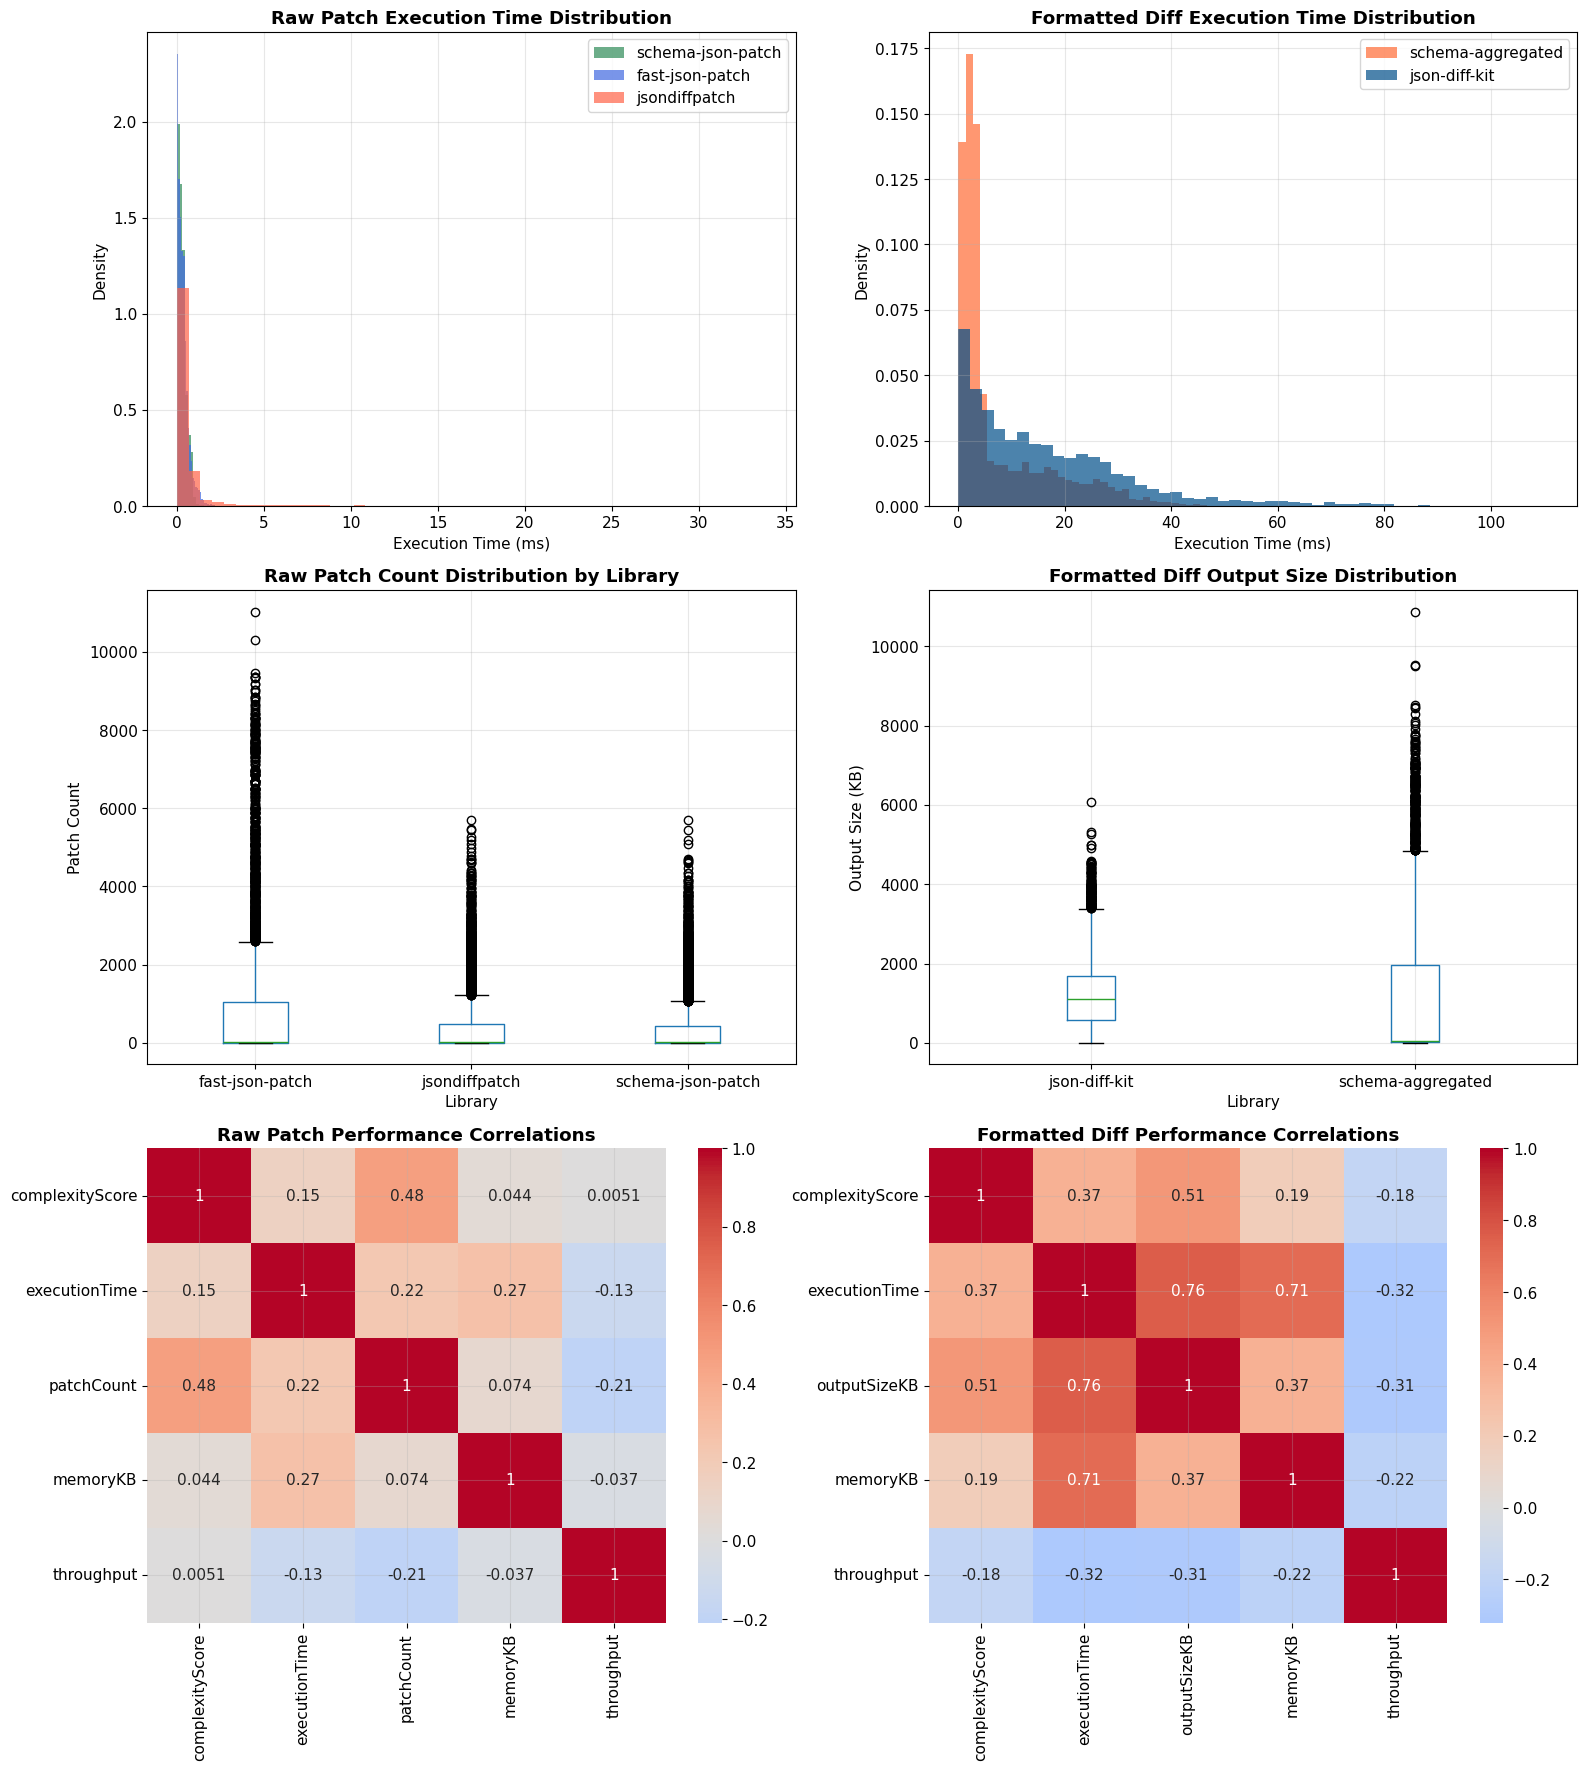

📊 Statistical Summary:

🚀 Raw Patch Performance Statistics:
                  executionTime                       patchCount                      throughput                              
                           mean    std    min     max       mean       std min    max       mean        std     min        max
library                                                                                                                       
fast-json-patch           0.358  0.337  0.006   4.399    905.416  1702.012   0  11030   8459.610  13601.519  227.33  176460.21
jsondiffpatch             1.215  3.589  0.006  33.864    430.494   823.502   0   5690   7134.143  11206.146   29.53  153846.15
schema-json-patch         0.320  0.293  0.003   7.906    396.258   775.923   0   5690  12252.478  23106.936  126.49  363636.36

🎨 Formatted Diff Performance Statistics:
                  executionTime                         outputSizeKB                           throughput                           
   

In [84]:
# Statistical Analysis and Distribution Visualization
if raw_df is not None and formatted_df is not None:
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Performance Distribution Analysis', fontsize=16, fontweight='bold')

    # 1. Raw Patch Execution Time Distribution
    ax1 = axes[0, 0]
    for lib in raw_df['library'].unique():
        lib_data = raw_df[raw_df['library'] == lib]['executionTime']
        ax1.hist(lib_data, bins=50, alpha=0.7, label=lib, 
                color=library_colors.get(lib, '#888888'), density=True)
    ax1.set_title('Raw Patch Execution Time Distribution', fontweight='bold')
    ax1.set_xlabel('Execution Time (ms)')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Formatted Diff Execution Time Distribution
    ax2 = axes[0, 1]
    for lib in formatted_df['library'].unique():
        lib_data = formatted_df[formatted_df['library'] == lib]['executionTime']
        ax2.hist(lib_data, bins=50, alpha=0.7, label=lib,
                color=formatted_diff_colors.get(lib, '#888888'), density=True)
    ax2.set_title('Formatted Diff Execution Time Distribution', fontweight='bold')
    ax2.set_xlabel('Execution Time (ms)')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Raw Patch Count Distribution
    ax3 = axes[1, 0]
    raw_df.boxplot(column='patchCount', by='library', ax=ax3)
    ax3.set_title('Raw Patch Count Distribution by Library', fontweight='bold')
    ax3.set_xlabel('Library')
    ax3.set_ylabel('Patch Count')
    plt.suptitle('')  # Remove automatic title

    # 4. Output Size Distribution
    ax4 = axes[1, 1]
    formatted_df.boxplot(column='outputSizeKB', by='library', ax=ax4)
    ax4.set_title('Formatted Diff Output Size Distribution', fontweight='bold')
    ax4.set_xlabel('Library')
    ax4.set_ylabel('Output Size (KB)')
    plt.suptitle('')  # Remove automatic title

    # 5. Performance vs Complexity Correlation Heatmap
    ax5 = axes[2, 0]
    correlation_data = raw_df[['complexityScore', 'executionTime', 'patchCount', 'memoryKB', 'throughput']].corr()
    sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=ax5)
    ax5.set_title('Raw Patch Performance Correlations', fontweight='bold')

    # 6. Formatted Diff Correlation Heatmap
    ax6 = axes[2, 1]
    formatted_correlation = formatted_df[['complexityScore', 'executionTime', 'outputSizeKB', 'memoryKB', 'throughput']].corr()
    sns.heatmap(formatted_correlation, annot=True, cmap='coolwarm', center=0, ax=ax6)
    ax6.set_title('Formatted Diff Performance Correlations', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Statistical Summary
    print("📊 Statistical Summary:")
    print("\n🚀 Raw Patch Performance Statistics:")
    raw_stats = raw_df.groupby('library').agg({
        'executionTime': ['mean', 'std', 'min', 'max'],
        'patchCount': ['mean', 'std', 'min', 'max'],
        'throughput': ['mean', 'std', 'min', 'max']
    }).round(3)
    print(raw_stats.to_string())

    print("\n🎨 Formatted Diff Performance Statistics:")
    formatted_stats = formatted_df.groupby('library').agg({
        'executionTime': ['mean', 'std', 'min', 'max'],
        'outputSizeKB': ['mean', 'std', 'min', 'max'],
        'throughput': ['mean', 'std', 'min', 'max']
    }).round(3)
    print(formatted_stats.to_string())

    # Key Insights
    print("\n🔍 Key Insights:")
    
    # Raw patch insights
    raw_mean_times = raw_df.groupby('library')['executionTime'].mean()
    fastest_raw = raw_mean_times.idxmin()
    slowest_raw = raw_mean_times.idxmax()
    print(f"  ⚡ Fastest raw patch library: {fastest_raw} ({raw_mean_times[fastest_raw]:.3f}ms avg)")
    print(f"  🐌 Slowest raw patch library: {slowest_raw} ({raw_mean_times[slowest_raw]:.3f}ms avg)")
    
    # Formatted diff insights
    formatted_mean_times = formatted_df.groupby('library')['executionTime'].mean()
    fastest_formatted = formatted_mean_times.idxmin()
    slowest_formatted = formatted_mean_times.idxmax()
    print(f"  🎨 Fastest formatted diff: {fastest_formatted} ({formatted_mean_times[fastest_formatted]:.3f}ms avg)")
    print(f"  🎭 Slowest formatted diff: {slowest_formatted} ({formatted_mean_times[slowest_formatted]:.3f}ms avg)")
    
    # Patch efficiency
    raw_patch_counts = raw_df.groupby('library')['patchCount'].mean()
    most_efficient = raw_patch_counts.idxmin()
    least_efficient = raw_patch_counts.idxmax()
    print(f"  🎯 Most efficient patches: {most_efficient} ({raw_patch_counts[most_efficient]:.1f} patches avg)")
    print(f"  📏 Least efficient patches: {least_efficient} ({raw_patch_counts[least_efficient]:.1f} patches avg)")

else:
    print("❌ Missing data for statistical analysis")


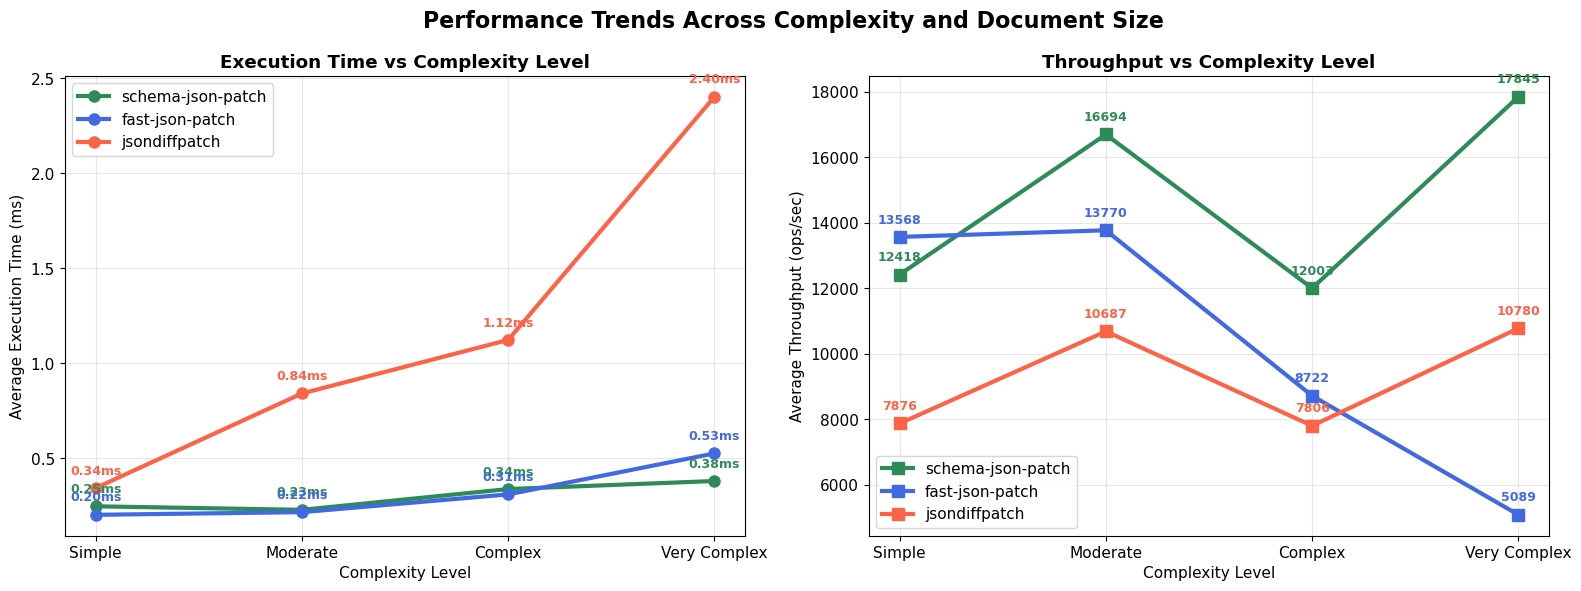

📈 Complexity trend line graphs created!


In [85]:
# 2.1 Execution Time vs Complexity Level - Line Graph
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Performance Trends Across Complexity and Document Size', fontsize=16, fontweight='bold')

# Left plot: Execution Time vs Complexity Level
ax1 = axes[0]
complexity_data = df.groupby(['library', 'complexityLevel']).agg({
    'executionTime': 'mean',
    'throughput': 'mean'
}).reset_index()

for library in df['library'].unique():
    lib_data = complexity_data[complexity_data['library'] == library]
    ax1.plot(lib_data['complexityLevel'], lib_data['executionTime'], 
             marker='o', linewidth=3, markersize=8, 
             color=library_colors[library], label=library)
    
    # Add value labels on points
    for _, row in lib_data.iterrows():
        ax1.annotate(f'{row["executionTime"]:.2f}ms', 
                    (row['complexityLevel'], row['executionTime']),
                    xytext=(0, 10), textcoords='offset points', 
                    ha='center', fontsize=9, fontweight='bold',
                    color=library_colors[library])

ax1.set_title('Execution Time vs Complexity Level', fontweight='bold')
ax1.set_xlabel('Complexity Level')
ax1.set_ylabel('Average Execution Time (ms)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Throughput vs Complexity Level  
ax2 = axes[1]
for library in df['library'].unique():
    lib_data = complexity_data[complexity_data['library'] == library]
    ax2.plot(lib_data['complexityLevel'], lib_data['throughput'], 
             marker='s', linewidth=3, markersize=8, 
             color=library_colors[library], label=library)
    
    # Add value labels on points
    for _, row in lib_data.iterrows():
        ax2.annotate(f'{row["throughput"]:.0f}', 
                    (row['complexityLevel'], row['throughput']),
                    xytext=(0, 10), textcoords='offset points', 
                    ha='center', fontsize=9, fontweight='bold',
                    color=library_colors[library])

ax2.set_title('Throughput vs Complexity Level', fontweight='bold')
ax2.set_xlabel('Complexity Level')
ax2.set_ylabel('Average Throughput (ops/sec)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📈 Complexity trend line graphs created!")


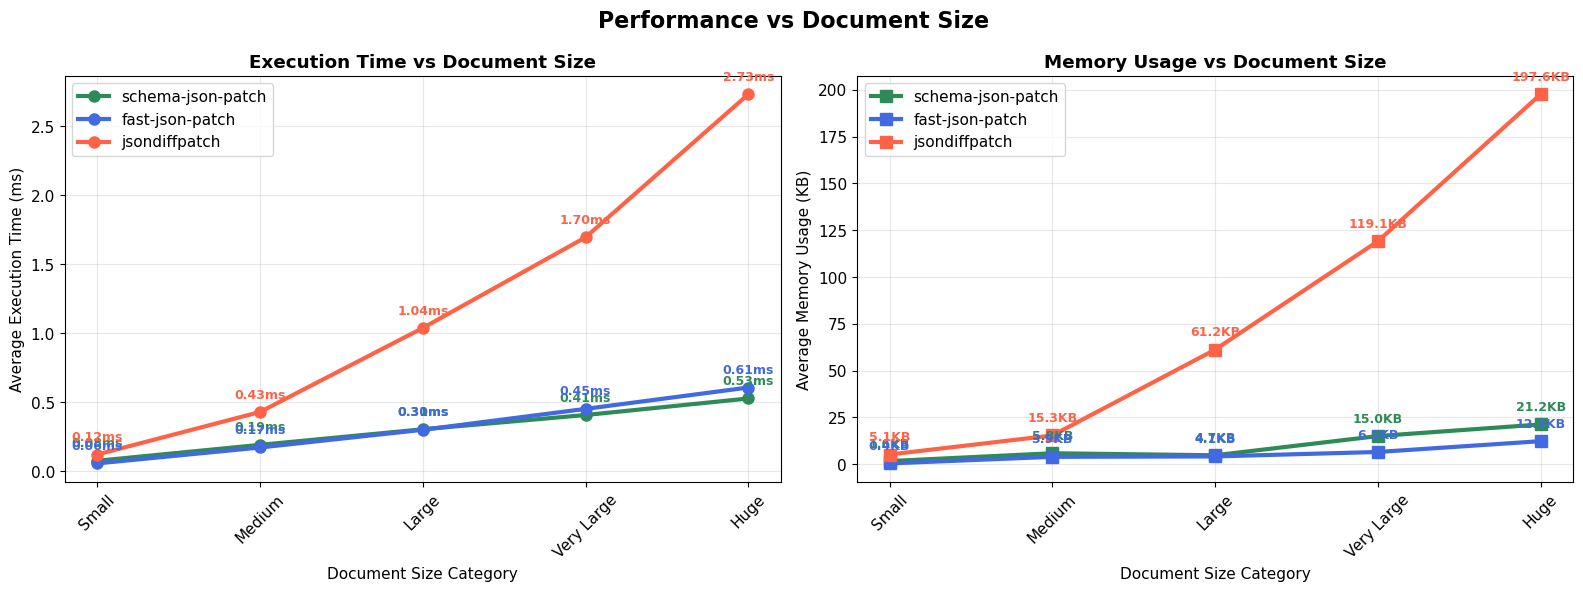

📈 Document size trend line graphs created!


In [86]:
# 2.2 Document Size Impact - Line Graph
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Performance vs Document Size', fontsize=16, fontweight='bold')

# Prepare document size data
size_data = df.groupby(['library', 'sizeCategory']).agg({
    'executionTime': 'mean',
    'memoryKB': 'mean',
    'patchCount': 'mean'
}).reset_index()

# Left plot: Execution Time vs Document Size
ax1 = axes[0]
for library in df['library'].unique():
    lib_data = size_data[size_data['library'] == library]
    ax1.plot(lib_data['sizeCategory'], lib_data['executionTime'], 
             marker='o', linewidth=3, markersize=8, 
             color=library_colors[library], label=library)
    
    # Add value labels on points
    for _, row in lib_data.iterrows():
        ax1.annotate(f'{row["executionTime"]:.2f}ms', 
                    (row['sizeCategory'], row['executionTime']),
                    xytext=(0, 10), textcoords='offset points', 
                    ha='center', fontsize=9, fontweight='bold',
                    color=library_colors[library])

ax1.set_title('Execution Time vs Document Size', fontweight='bold')
ax1.set_xlabel('Document Size Category')
ax1.set_ylabel('Average Execution Time (ms)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Right plot: Memory Usage vs Document Size
ax2 = axes[1]
for library in df['library'].unique():
    lib_data = size_data[size_data['library'] == library]
    ax2.plot(lib_data['sizeCategory'], lib_data['memoryKB'], 
             marker='s', linewidth=3, markersize=8, 
             color=library_colors[library], label=library)
    
    # Add value labels on points
    for _, row in lib_data.iterrows():
        ax2.annotate(f'{row["memoryKB"]:.1f}KB', 
                    (row['sizeCategory'], row['memoryKB']),
                    xytext=(0, 10), textcoords='offset points', 
                    ha='center', fontsize=9, fontweight='bold',
                    color=library_colors[library])

ax2.set_title('Memory Usage vs Document Size', fontweight='bold')
ax2.set_xlabel('Document Size Category')
ax2.set_ylabel('Average Memory Usage (KB)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("📈 Document size trend line graphs created!")


In [87]:
# 3.1 Performance Radar Chart
fig = go.Figure()

# Calculate normalized metrics for radar chart (0-100 scale, higher is better)
libraries = df['library'].unique()
metrics_data = []

for library in libraries:
    lib_data = df[df['library'] == library]
    
    # Normalize metrics (higher score = better performance)
    speed_score = 100 - (lib_data['executionTime'].mean() / df['executionTime'].max() * 100)
    memory_score = 100 - (lib_data['memoryKB'].mean() / df['memoryKB'].max() * 100)
    throughput_score = (lib_data['throughput'].mean() / df['throughput'].max() * 100)
    patch_score = 100 - (lib_data['patchCount'].mean() / df['patchCount'].max() * 100)
    accuracy_score = lib_data['accuracy'].mean() * 100
    
    metrics_data.append({
        'library': library,
        'Speed': speed_score,
        'Memory Efficiency': memory_score,
        'Throughput': throughput_score,
        'Patch Efficiency': patch_score,
        'Accuracy': accuracy_score
    })

# Create radar chart
categories = ['Speed', 'Memory Efficiency', 'Throughput', 'Patch Efficiency', 'Accuracy']

for metric in metrics_data:
    values = [metric[cat] for cat in categories]
    values += [values[0]]  # Close the radar chart
    
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories + [categories[0]],
        fill='toself',
        name=metric['library'],
        line=dict(color=library_colors[metric['library']], width=3),
        fillcolor=library_colors[metric['library']].replace(')', ', 0.1)').replace('rgb', 'rgba'),
        hovertemplate=f"<b>{metric['library']}</b><br>" +
                     "%{theta}: %{r:.1f}/100<br>" +
                     "<extra></extra>"
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100],
            tickfont=dict(size=10)
        )
    ),
    title={
        'text': "Performance Radar Chart - Multi-Dimensional Comparison<br><sub>Higher values indicate better performance (0-100 scale)</sub>",
        'x': 0.5,
        'font': {'size': 16}
    },
    font=dict(size=12),
    height=600,
    showlegend=True
)

fig.show()
print("🎯 Performance radar chart created!")


🎯 Performance radar chart created!


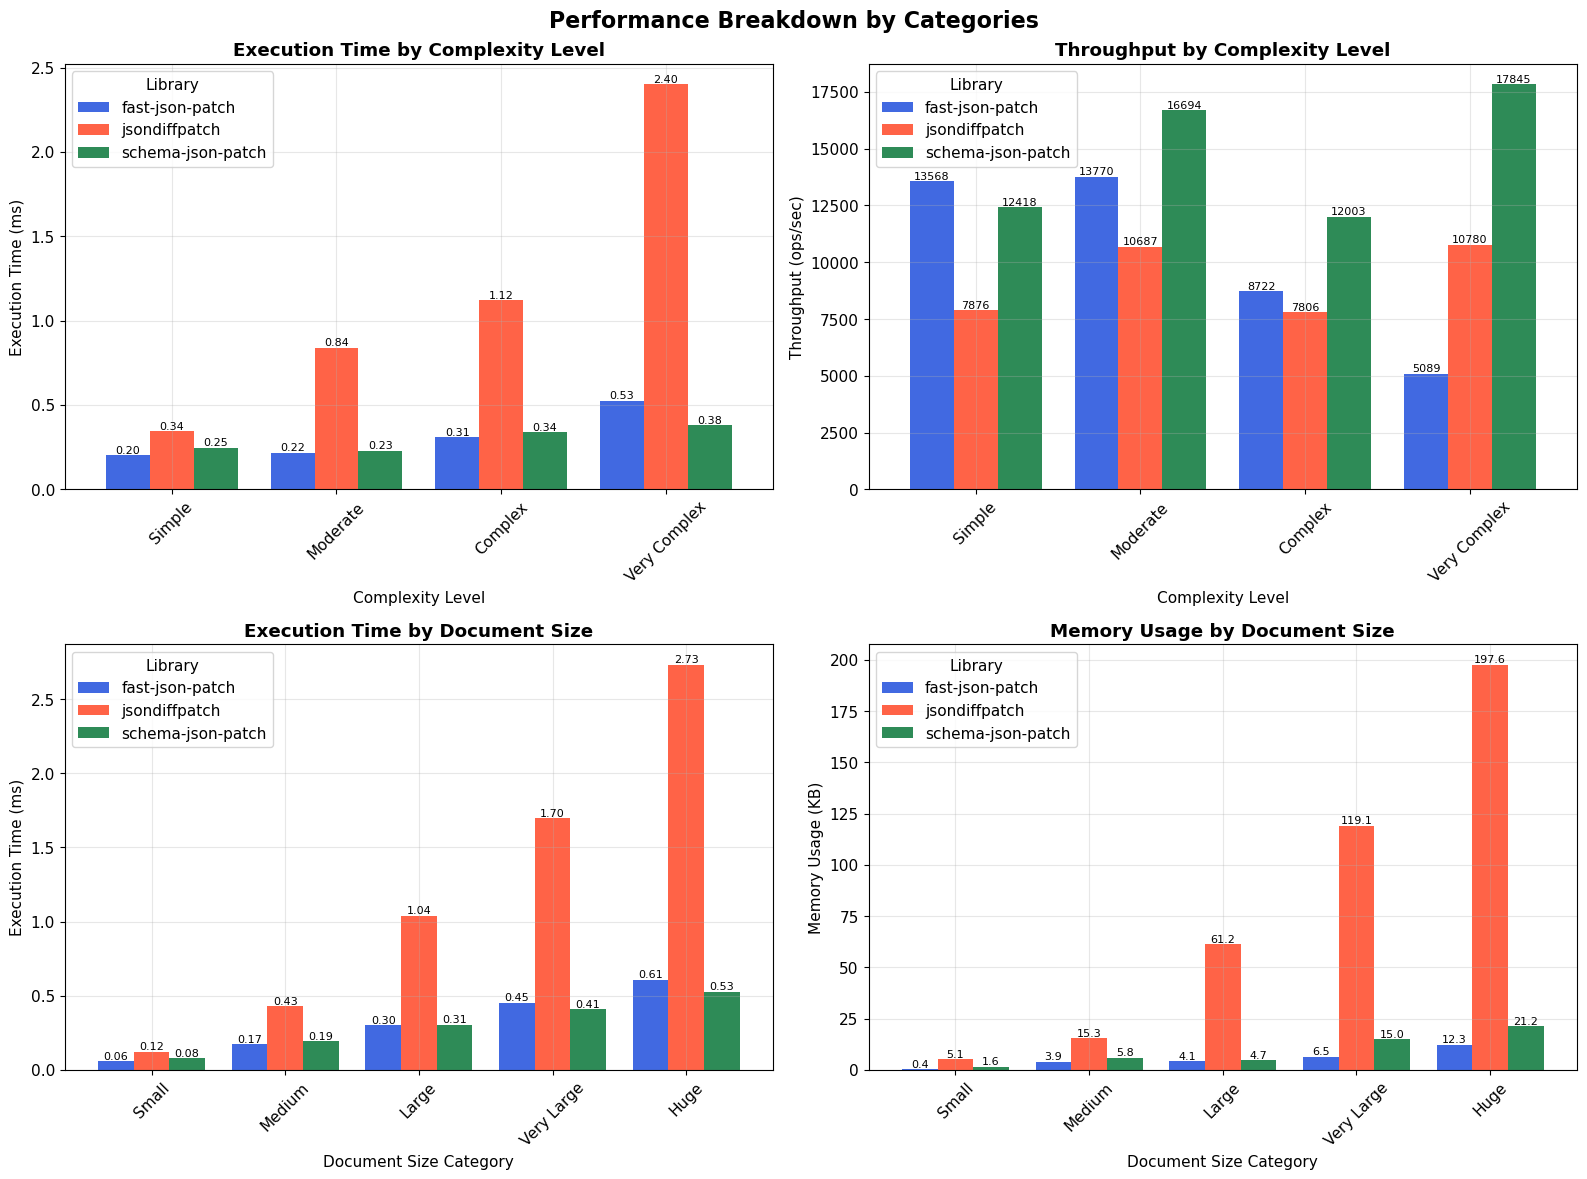

📊 Grouped bar charts by category created!


In [88]:
# 4.1 Performance by Complexity Level - Grouped Bar Chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Breakdown by Categories', fontsize=16, fontweight='bold')

# 1. Execution Time by Complexity Level
ax1 = axes[0, 0]
complex_pivot = complexity_data.pivot(index='complexityLevel', columns='library', values='executionTime')
complex_pivot.plot(kind='bar', ax=ax1, color=[library_colors[lib] for lib in complex_pivot.columns], width=0.8)
ax1.set_title('Execution Time by Complexity Level', fontweight='bold')
ax1.set_ylabel('Execution Time (ms)')
ax1.set_xlabel('Complexity Level')
ax1.legend(title='Library')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', fontsize=8)

# 2. Throughput by Complexity Level
ax2 = axes[0, 1]
throughput_pivot = complexity_data.pivot(index='complexityLevel', columns='library', values='throughput')
throughput_pivot.plot(kind='bar', ax=ax2, color=[library_colors[lib] for lib in throughput_pivot.columns], width=0.8)
ax2.set_title('Throughput by Complexity Level', fontweight='bold')
ax2.set_ylabel('Throughput (ops/sec)')
ax2.set_xlabel('Complexity Level')
ax2.legend(title='Library')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.0f', fontsize=8)

# 3. Execution Time by Document Size
ax3 = axes[1, 0]
size_pivot = size_data.pivot(index='sizeCategory', columns='library', values='executionTime')
size_pivot.plot(kind='bar', ax=ax3, color=[library_colors[lib] for lib in size_pivot.columns], width=0.8)
ax3.set_title('Execution Time by Document Size', fontweight='bold')
ax3.set_ylabel('Execution Time (ms)')
ax3.set_xlabel('Document Size Category')
ax3.legend(title='Library')
ax3.tick_params(axis='x', rotation=45)

# Add value labels on bars
for container in ax3.containers:
    ax3.bar_label(container, fmt='%.2f', fontsize=8)

# 4. Memory Usage by Document Size
ax4 = axes[1, 1]
memory_pivot = size_data.pivot(index='sizeCategory', columns='library', values='memoryKB')
memory_pivot.plot(kind='bar', ax=ax4, color=[library_colors[lib] for lib in memory_pivot.columns], width=0.8)
ax4.set_title('Memory Usage by Document Size', fontweight='bold')
ax4.set_ylabel('Memory Usage (KB)')
ax4.set_xlabel('Document Size Category')
ax4.legend(title='Library')
ax4.tick_params(axis='x', rotation=45)

# Add value labels on bars
for container in ax4.containers:
    ax4.bar_label(container, fmt='%.1f', fontsize=8)

plt.tight_layout()
plt.show()

print("📊 Grouped bar charts by category created!")


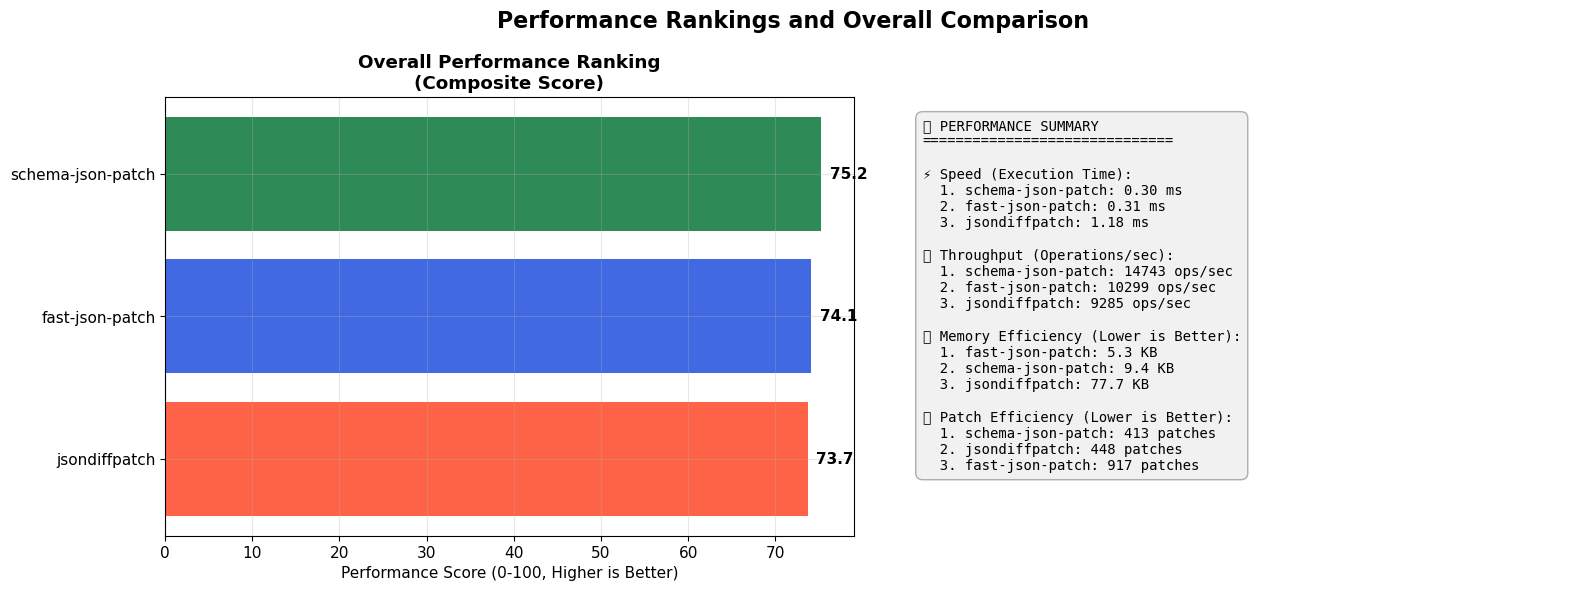

🏆 Performance summary and rankings created!

📊 ANALYSIS COMPLETE!
📈 Total data points analyzed: 15,000
🏷️ Libraries compared: schema-json-patch, fast-json-patch, jsondiffpatch
✅ All visualizations use simple, clear formats:
   - Bar charts for direct comparisons
   - Line graphs for trends
   - Radar chart for multi-dimensional view
   - All charts include value labels for clarity


In [89]:
# 5.1 Performance Rankings and Summary
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Performance Rankings and Overall Comparison', fontsize=16, fontweight='bold')

# Left plot: Overall Performance Ranking (composite score)
ax1 = axes[0]
ranking_data = []
for library in df['library'].unique():
    lib_data = df[df['library'] == library]
    
    # Calculate composite performance score (higher is better)
    speed_norm = 100 - (lib_data['executionTime'].mean() / df['executionTime'].max() * 100)
    throughput_norm = (lib_data['throughput'].mean() / df['throughput'].max() * 100)
    memory_norm = 100 - (lib_data['memoryKB'].mean() / df['memoryKB'].max() * 100)
    patch_norm = 100 - (lib_data['patchCount'].mean() / df['patchCount'].max() * 100)
    accuracy_norm = lib_data['accuracy'].mean() * 100
    
    # Weighted composite score
    composite_score = (speed_norm * 0.3 + throughput_norm * 0.25 + 
                      memory_norm * 0.2 + patch_norm * 0.15 + accuracy_norm * 0.1)
    
    ranking_data.append({
        'library': library,
        'composite_score': composite_score
    })

ranking_df = pd.DataFrame(ranking_data).sort_values('composite_score', ascending=True)

bars = ax1.barh(ranking_df['library'], ranking_df['composite_score'], 
               color=[library_colors[lib] for lib in ranking_df['library']])
ax1.set_title('Overall Performance Ranking\n(Composite Score)', fontweight='bold')
ax1.set_xlabel('Performance Score (0-100, Higher is Better)')

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}', ha='left', va='center', fontweight='bold')

# Right plot: Performance Summary Table (as bar chart)
ax2 = axes[1]
ax2.axis('off')

# Create summary statistics table
summary_text = []
summary_text.append("🏆 PERFORMANCE SUMMARY")
summary_text.append("=" * 30)
summary_text.append("")

# Rankings by individual metrics
time_ranking = df.groupby('library')['executionTime'].mean().sort_values()
throughput_ranking = df.groupby('library')['throughput'].mean().sort_values(ascending=False)
memory_ranking = df.groupby('library')['memoryKB'].mean().sort_values()
patch_ranking = df.groupby('library')['patchCount'].mean().sort_values()

summary_text.append("⚡ Speed (Execution Time):")
for i, (lib, time) in enumerate(time_ranking.items(), 1):
    summary_text.append(f"  {i}. {lib}: {time:.2f} ms")

summary_text.append("")
summary_text.append("🚀 Throughput (Operations/sec):")
for i, (lib, tput) in enumerate(throughput_ranking.items(), 1):
    summary_text.append(f"  {i}. {lib}: {tput:.0f} ops/sec")

summary_text.append("")
summary_text.append("💾 Memory Efficiency (Lower is Better):")
for i, (lib, mem) in enumerate(memory_ranking.items(), 1):
    summary_text.append(f"  {i}. {lib}: {mem:.1f} KB")

summary_text.append("")
summary_text.append("📏 Patch Efficiency (Lower is Better):")
for i, (lib, patches) in enumerate(patch_ranking.items(), 1):
    summary_text.append(f"  {i}. {lib}: {patches:.0f} patches")

# Display as text
ax2.text(0.05, 0.95, '\n'.join(summary_text), 
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.3))

plt.tight_layout()
plt.show()

print("🏆 Performance summary and rankings created!")
print("\n" + "="*50)
print("📊 ANALYSIS COMPLETE!")
print("="*50)
print(f"📈 Total data points analyzed: {len(df):,}")
print(f"🏷️ Libraries compared: {', '.join(df['library'].unique())}")
print("✅ All visualizations use simple, clear formats:")
print("   - Bar charts for direct comparisons")
print("   - Line graphs for trends") 
print("   - Radar chart for multi-dimensional view")
print("   - All charts include value labels for clarity")


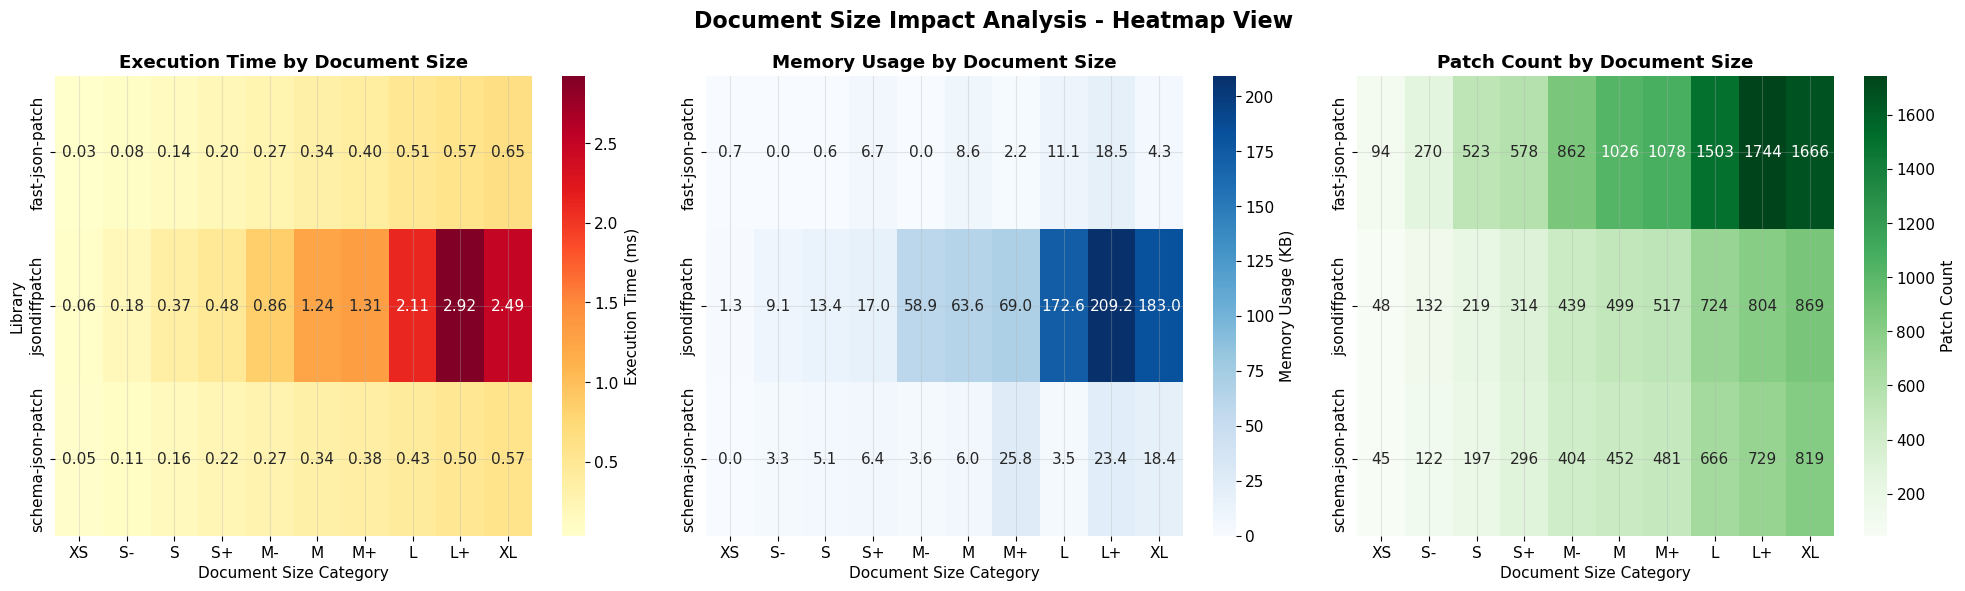

🔥 Document size heatmap analysis created!


In [90]:
# 6.1 Document Size Heatmap with Performance Metrics
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Document Size Impact Analysis - Heatmap View', fontsize=16, fontweight='bold')

# Create document size bins for better visualization
df['docSizeBin'] = pd.cut(df['documentSize'], 
                         bins=10, 
                         labels=['XS', 'S-', 'S', 'S+', 'M-', 'M', 'M+', 'L', 'L+', 'XL'])

# 1. Execution Time Heatmap
pivot_time = df.pivot_table(values='executionTime', 
                           index='library', 
                           columns='docSizeBin', 
                           aggfunc='mean')

sns.heatmap(pivot_time, annot=True, fmt='.2f', cmap='YlOrRd', 
           ax=axes[0], cbar_kws={'label': 'Execution Time (ms)'})
axes[0].set_title('Execution Time by Document Size', fontweight='bold')
axes[0].set_xlabel('Document Size Category')
axes[0].set_ylabel('Library')

# 2. Memory Usage Heatmap  
pivot_memory = df.pivot_table(values='memoryKB', 
                             index='library', 
                             columns='docSizeBin', 
                             aggfunc='mean')

sns.heatmap(pivot_memory, annot=True, fmt='.1f', cmap='Blues', 
           ax=axes[1], cbar_kws={'label': 'Memory Usage (KB)'})
axes[1].set_title('Memory Usage by Document Size', fontweight='bold')
axes[1].set_xlabel('Document Size Category')
axes[1].set_ylabel('')

# 3. Patch Count Heatmap
pivot_patches = df.pivot_table(values='patchCount', 
                              index='library', 
                              columns='docSizeBin', 
                              aggfunc='mean')

sns.heatmap(pivot_patches, annot=True, fmt='.0f', cmap='Greens', 
           ax=axes[2], cbar_kws={'label': 'Patch Count'})
axes[2].set_title('Patch Count by Document Size', fontweight='bold')
axes[2].set_xlabel('Document Size Category')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

print("🔥 Document size heatmap analysis created!")


In [91]:
# Performance improvement analysis
print("🚀 PERFORMANCE IMPROVEMENT ANALYSIS")
print("=" * 50)

# Compare schema-json-patch against others
schema_data = df[df['library'] == 'schema-json-patch']
if len(schema_data) > 0:
    schema_mean_time = schema_data['executionTime'].mean()
    schema_mean_patches = schema_data['patchCount'].mean()
    
    print(f"📊 schema-json-patch baseline:")
    print(f"  Average execution time: {schema_mean_time:.2f} ms")
    print(f"  Average patch count: {schema_mean_patches:.1f}")
    print()
    
    for other_lib in ['fast-json-patch', 'jsondiffpatch']:
        other_data = df[df['library'] == other_lib]
        if len(other_data) > 0:
            other_mean_time = other_data['executionTime'].mean()
            other_mean_patches = other_data['patchCount'].mean()
            
            time_improvement = ((other_mean_time - schema_mean_time) / other_mean_time) * 100
            patch_improvement = ((other_mean_patches - schema_mean_patches) / other_mean_patches) * 100
            
            print(f"🔬 schema-json-patch vs {other_lib}:")
            print(f"  Time difference: {time_improvement:+.1f}%")
            print(f"  Patch count difference: {patch_improvement:+.1f}%")
            print(f"  Throughput ratio: {other_data['throughput'].mean() / schema_data['throughput'].mean():.2f}x")
            print()

# Overall rankings
print("🏆 OVERALL PERFORMANCE RANKINGS:")
print("-" * 40)

# Rank by execution time (lower is better)
time_ranking = df.groupby('library')['executionTime'].mean().sort_values()
print("⚡ Execution Time (lower is better):")
for i, (library, time) in enumerate(time_ranking.items(), 1):
    print(f"  {i}. {library}: {time:.2f} ms")

print()

# Rank by patch count (lower is better)
patch_ranking = df.groupby('library')['patchCount'].mean().sort_values()
print("📏 Patch Count (lower is better):")
for i, (library, patches) in enumerate(patch_ranking.items(), 1):
    print(f"  {i}. {library}: {patches:.1f} patches")

print()

# Rank by throughput (higher is better)
throughput_ranking = df.groupby('library')['throughput'].mean().sort_values(ascending=False)
print("🚀 Throughput (higher is better):")
for i, (library, tput) in enumerate(throughput_ranking.items(), 1):
    print(f"  {i}. {library}: {tput:.0f} ops/sec")


🚀 PERFORMANCE IMPROVEMENT ANALYSIS
📊 schema-json-patch baseline:
  Average execution time: 0.30 ms
  Average patch count: 412.6

🔬 schema-json-patch vs fast-json-patch:
  Time difference: +4.9%
  Patch count difference: +55.0%
  Throughput ratio: 0.70x

🔬 schema-json-patch vs jsondiffpatch:
  Time difference: +74.7%
  Patch count difference: +7.9%
  Throughput ratio: 0.63x

🏆 OVERALL PERFORMANCE RANKINGS:
----------------------------------------
⚡ Execution Time (lower is better):
  1. schema-json-patch: 0.30 ms
  2. fast-json-patch: 0.31 ms
  3. jsondiffpatch: 1.18 ms

📏 Patch Count (lower is better):
  1. schema-json-patch: 412.6 patches
  2. jsondiffpatch: 447.8 patches
  3. fast-json-patch: 917.3 patches

🚀 Throughput (higher is better):
  1. schema-json-patch: 14743 ops/sec
  2. fast-json-patch: 10299 ops/sec
  3. jsondiffpatch: 9285 ops/sec
